<a href="https://colab.research.google.com/github/Rohit1217/Flow/blob/main/Flow_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
!pip install matplotlib

In [94]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset,DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [95]:
Device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [96]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)

data=trainset.data
data=data.to(dtype=torch.float32)
norm = transforms.Normalize((128,),(128,))
data=norm(data)
data_target=data*0.5+0.5
data=data.view(60000,784)
data=data.to(dtype=torch.float32)

data_target=data_target.view(60000,784)
trainset=TensorDataset(data,data_target)
trainloader=DataLoader(trainset,batch_size=256,shuffle=True)


In [97]:
def gaussian_pdf(x, mean, std_dev):
    return 1 / (torch.sqrt(2 * torch.tensor(np.pi)) * std_dev) * torch.exp(-0.5 * ((x - mean) / std_dev)**2)


In [98]:
class AffineCoupling(nn.Module):
  def __init__(self,input_layer):
    super(AffineCoupling,self).__init__()
    self.inp=input_layer//2
    self.fc1=nn.Linear(self.inp,1000).to(Device)
    self.fc2=nn.Linear(1000,1000).to(Device)
    self.fc3=nn.Linear(1000,1000).to(Device)
    self.fc4=nn.Linear(1000,1000).to(Device)
    self.fc5=nn.Linear(1000,self.inp).to(Device)
    #self.fc6=nn.Linear(1000,self.inp).to(Device)
    self.bn1=nn.BatchNorm1d(1000).to(Device)
    self.bn2=nn.BatchNorm1d(1000).to(Device)
    self.bn3=nn.BatchNorm1d(1000).to(Device)
    self.bn4=nn.BatchNorm1d(1000).to(Device)
    self.bn5=nn.BatchNorm1d(self.inp).to(Device)


  def coupling_shuffler(self,x):
    b,c=x.shape
    layer=torch.rand(b,c).to(Device)
    for i in range(c):
      if i%2==0:
        layer[:,c//2+i//2]=x[:,i]
      else:
        layer[:,i//2]=x[:,i]
    return layer

  def inverse(self,x):
    b,c=x.shape
    x0=x[:,:c//2]
    x1=x[:,c//2:]
    z=F.relu(self.bn1(self.fc1(x0)))
    z=F.relu(self.bn2(self.fc2(z)))
    z=F.relu(self.bn3(self.fc3(z)))
    z=F.relu(self.bn4(self.fc4(z)))
    z=F.relu(self.bn5(self.fc5(z)))
    x1=x1-z
    x=torch.cat((x0, x1), 1)
    layer=torch.rand(b,c).to(Device)
    for i in range(c):
      if i>=c//2:
        layer[:,2*i-c]=x[:,i]
      else:
        layer[:,i*2+1]=x[:,i]
    return layer


  def forward(self,x):
    b,c=x.shape
    x=self.coupling_shuffler(x)
    x0=x[:,:c//2]
    x1=x[:,c//2:]

    z=F.relu(self.bn1(self.fc1(x0)))
    z=F.relu(self.bn2(self.fc2(z)))
    z=F.relu(self.bn3(self.fc3(z)))
    z=F.relu(self.bn4(self.fc4(z)))
    z=F.relu(self.bn5(self.fc5(z)))

    x1=x1+z
    x=torch.cat((x0, x1), 1)
    return x

x=torch.randn(2,20)
print(x)
aff=AffineCoupling(20)
y=aff(x)
print(aff(x))
aff.inverse(y)


tensor([[ 0.3792, -0.1328,  0.5969,  0.5096, -0.5445, -0.1116,  0.1289,  0.8103,
         -1.1764,  0.0048,  1.2339,  0.1276,  0.0635,  1.8955, -0.3539, -0.0790,
          0.2385, -0.5234,  0.5105,  0.1851],
        [-0.7651, -1.4331, -0.3273, -0.1039,  1.9488, -0.3149, -0.0609,  0.2056,
          0.3700,  0.4947, -1.3425, -2.4390,  1.1718, -0.8352, -0.3367,  0.9749,
          0.4978, -1.2337,  1.4101,  0.5045]])
tensor([[-0.1328,  0.5096, -0.1116,  0.8103,  0.0048,  0.1276,  1.8955, -0.0790,
         -0.5234,  0.1851,  0.3792,  1.5966,  0.2151,  1.1285, -1.1764,  1.2339,
          0.0635, -0.3539,  0.2385,  1.5104],
        [-1.4331, -0.1039, -0.3149,  0.2056,  0.4947, -2.4390, -0.8352,  0.9749,
         -1.2337,  0.5045, -0.4024, -0.3273,  1.9488, -0.0609,  1.3700, -0.3426,
          2.1022,  0.6632,  1.4977,  1.4101]], device='cuda:0',
       grad_fn=<CatBackward0>)


tensor([[ 0.3792, -0.1328,  0.5969,  0.5096, -0.5445, -0.1116,  0.1289,  0.8103,
         -1.1764,  0.0048,  1.2339,  0.1276,  0.0635,  1.8955, -0.3539, -0.0790,
          0.2385, -0.5234,  0.5105,  0.1851],
        [-0.7651, -1.4331, -0.3273, -0.1039,  1.9488, -0.3149, -0.0609,  0.2056,
          0.3700,  0.4947, -1.3425, -2.4390,  1.1718, -0.8352, -0.3367,  0.9749,
          0.4978, -1.2337,  1.4101,  0.5045]], device='cuda:0',
       grad_fn=<CopySlices>)

In [99]:
class Rescale(nn.Module):
    def __init__(self, input_layer):
        super(Rescale, self).__init__()
        #self.weight = nn.Parameter(torch.ones(input_layer)).to(Device)
        self.register_parameter(name='weight', param=torch.nn.Parameter(torch.ones(input_layer)))


    def forward(self, x):
        x=self.weight * x
        y=self.weight+x-x
        return x,y

res=Rescale(6).to(Device)
x=torch.tensor(6)

for name,param in res.named_parameters():
  print(name,param,'a')


weight Parameter containing:
tensor([1., 1., 1., 1., 1., 1.], device='cuda:0', requires_grad=True) a


In [100]:
class Flow(nn.Module):
  def __init__(self,input_layer):
    super(Flow,self).__init__()
    self.inp=input_layer
    self.ac1=AffineCoupling(input_layer)
    self.ac2=AffineCoupling(input_layer)
    self.ac3=AffineCoupling(input_layer)
    #self.ac4=AffineCoupling(input_layer)
    #self.ac5=AffineCoupling(input_layer)
    #self.ac6=AffineCoupling(input_layer)
    self.scaling=Rescale(input_layer)

  def inverse(self,x):
    with torch.no_grad():
      scaling_diag=self.scaling.weight.data
      x = torch.matmul(x, torch.diag(torch.reciprocal(torch.exp(scaling_diag))))
      #x=self.ac5.inverse(x)
      #x=self.ac6.inverse(x)
      #x=self.ac4.inverse(x)
      x=self.ac3.inverse(x)
      x=self.ac2.inverse(x)
      x=self.ac1.inverse(x)
      return x


  def forward(self,x):
    x=self.ac1(x)
    x=self.ac2(x)
    x=self.ac3(x)
    #x=self.ac4(x)
    #x=self.ac5(x)
    #x=self.ac6(x)
    x,y= self.scaling(x)
    return x,y

x=torch.rand(2,6)
x=x.to(Device)
y1=x
flows=Flow(6)
flows=flows.to(Device)
y,s=flows(x)
#x=flows.inverse(y)
#print(y1,x,y,s)


In [ ]:
for name,param in flows.named_parameters():
  print(name,param)

In [102]:
def loss_f(x,diag):
  #x=0.5*(torch.pow(x,2))+0.5*torch.log(torch.tensor(2*np.pi))
  #torch.sum(diag)
  #print(torch.mean(-(diag)+(0.5*(torch.pow(x,2))+0.5*torch.log(torch.tensor(2*np.pi)))))
  return torch.mean(-torch.sum(diag,dim=1)+torch.sum(0.5*(torch.pow(x,2))+0.5*torch.log(torch.tensor(2*np.pi)),dim=1))

flow=Flow(784).to(Device)
x=torch.randn(2,784).to(Device)
y,s=flow(x)
print(y,s)
loss_f(y,s)

tensor([[-0.9129,  0.2069, -1.5496,  ...,  0.5987,  1.4864,  0.3451],
        [-0.4504, -0.4716, -1.0993,  ...,  1.8698,  0.6702,  2.3877]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
       device='cuda:0', grad_fn=<SubBackward0>)


tensor(779.9637, device='cuda:0', grad_fn=<MeanBackward0>)

In [121]:
epochs=1000
model=Flow(784)
optimizer=optim.Adam(model.parameters(),lr=0.001)
model=model.to(Device)

In [122]:
model.train()
for epoch in range(epochs):
  total_loss=0
  count=0
  for input,_ in trainloader:
    input=input.to(Device)
    input,scaling=model(input)
    loss=loss_f(input,scaling)

    total_loss+=loss.item()
    count+=1

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

  print(f'total_loss={total_loss},average_loss={total_loss/count},epoch={epoch}')


total_loss=2048.7728769779205,average_loss=8.718182455225193,epoch=0


KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
  #model.eval()
  x=data[:64]
  #print(x)
  #x=torch.randn(64,784)
  x=x.to('cuda:0')
  print(x[0])
  x,y=flow(x)
  x=flow.inverse(x)
  print(x[0])
  x=x*0.5+0.5
  x = x.view(8, 8, 28, 28)
  x = x.to('cpu')
  image_np = x.detach().numpy()

  # Create a figure and a set of subplots arranged in an 8x8 grid
  fig, axes = plt.subplots(8, 8, figsize=(8, 8))

  # Iterate through the subplots and display each image
  for i in range(8):
      for j in range(8):
          axes[i, j].imshow(image_np[i, j], cmap='gray')
          axes[i, j].axis('off')  # Turn off axis labels

  plt.show()

In [ ]:
print(model.scaling.weight.data)

In [ ]:
data[0]

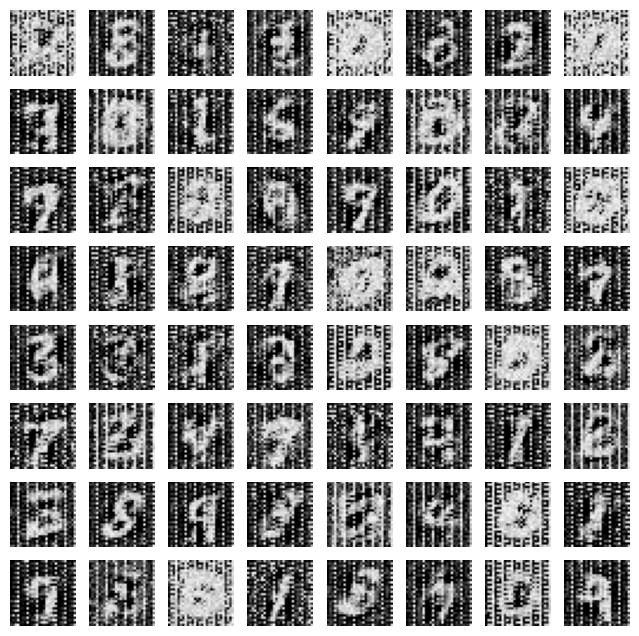

In [123]:
with torch.no_grad():
  #model.eval()
  x=data[:64]
  #print(x)
  x=torch.rand(64,784)
  x=x.to('cuda:0')
  #x=model(x)

  x=model.inverse(x)
  x = torch.clamp(x, min=-1, max=1)
  x=x*0.5+0.5
  x = x.view(8,8, 28, 28)
  x = x.to('cpu')
  image_np = x.detach().numpy()


  # Create a figure and a set of subplots arranged in an 8x8 grid
  fig, axes = plt.subplots(8, 8, figsize=(8, 8))

  # Iterate through the subplots and display each image
  for i in range(8):
      for j in range(8):
          axes[i, j].imshow(image_np[i, j], cmap='gray')
          axes[i, j].axis('off')  # Turn off axis labels

  plt.show()